In [254]:
import numpy as np
from scipy.interpolate import griddata
from scipy.linalg import lu_solve, lu_factor, solve, solve_banded
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import plotly.graph_objects as go
from numba import jit    

|       | Description |
| ----------- | ----------- |
| Author      | Kamin Atsavasirilert (MSFE student at UIUC)|
| Date   | 03/20/2024        |
|Email|kamina2@illinois.edu|
|Idea| Use Crank-Nickolson and Thomas algorithms for option pricing |

In [362]:
@jit
def TDMA(a,b,c,d):
    n = len(d)
    w= np.zeros(n-1,float)
    g= np.zeros(n, float)
    p = np.zeros(n,float)
    
    w[0] = c[0]/b[0]
    g[0] = d[0]/b[0]

    for i in range(1,n-1):
        w[i] = c[i]/(b[i] - a[i-1]*w[i-1])
    for i in range(1,n):
        g[i] = (d[i] - a[i-1]*g[i-1])/(b[i] - a[i-1]*w[i-1])
    p[n-1] = g[n-1]
    for i in range(n-1,0,-1):
        p[i-1] = g[i-1] - w[i-1]*p[i]
    return p

class Crank_Nicolson():
    def __init__(self, Gtau, Gs, T, S, strike, r, sigma, use_lv, is_call, max_S_time=2, eps = 1e-3):
        self.Gtau = Gtau
        self.Gs = Gs
        self.T = T
        self.S = S
        self.is_call = is_call
        self.strike = strike
        self.r = r
        self.sigma = sigma        
        self.ds = max_S_time * self.S / (self.Gs - 1)
        self.dt = self.T / (self.Gtau - 1)
        self.use_lv = use_lv
        self.eps = eps
    def griding_S_T(self):
        self.t_grid, self.S_grid = np.meshgrid(np.arange(self.Gtau, dtype=np.float64), np.arange(self.Gs, dtype=np.float64))
        self.t_grid[:, 0] = self.t_grid[:, 0] + self.eps
        self.S_grid[0, :] = self.S_grid[0, :] + self.eps
        self.actual_t_grid = self.T - self.t_grid * self.dt
        self.actual_s_grid = self.ds * self.S_grid
        self.reamining_T_grid = self.t_grid * self.dt
#         self.log_strike_grid = np.log(self.strike / (self.actual_s_grid * np.exp(self.r * self.reamining_T_grid)))
        self.log_strike_grid = np.log(self.actual_s_grid / (self.S * np.exp(self.r * self.reamining_T_grid)))
        
    def create_grid(self):
        self.grid = np.zeros((self.Gs, self.Gtau))
        if self.is_call:
            self.grid[:, 0] = np.where(self.actual_s_grid[:, 0] - self.strike > 0 , 
                                       self.actual_s_grid[:, 0] - self.strike, 0)
            self.grid[0, :] = 0
            self.grid[self.Gs-1, :] = self.actual_s_grid[self.Gs-1,0] - \
                                      self.strike * np.exp(-self.r*(self.T - \
                                                                    self.actual_t_grid[self.Gs-1, :]))
        else:
            self.grid[:, 0] = np.where(self.strike - self.actual_s_grid[:, 0] > 0 , 
                                       self.strike - self.actual_s_grid[:, 0], 0)
            self.grid[0, :] = self.strike * np.exp(-self.r*(self.T - self.actual_t_grid[0, :]))
            self.grid[self.Gs-1, :] =  0
    
    def calculate_alpha_beta_gamma(self):
        tmp_sigma_sqr_i = (self.sigma * self.S_grid)**2
        tmp_r_i = self.r * self.S_grid
        self.alpha = self.dt *(tmp_sigma_sqr_i.copy() - tmp_r_i.copy()) / 4
        self.beta = - self.dt * (tmp_sigma_sqr_i.copy() + self.r) / 2
        self.gamma = self.dt * (tmp_sigma_sqr_i.copy() + tmp_r_i.copy()) / 4
    
    def get_local_vol(self, rho, eta, gamma, V, V_prime, theta, kappa1, kappa2):
        def cal_theta_T(rho, eta, gamma, V, V_prime, theta, k, T, kappa1, kappa2):
            return theta * T + (V - theta) * (1-np.exp(-kappa1 * T)) / kappa1 + \
                   (V_prime - theta) * kappa1 * ((1-np.exp(-kappa2 * T)) / kappa2 - (1 - \
                   np.exp(-kappa1 * T)) / kappa1 ) / (kappa1 - kappa2)

        def cal_phi_theta_T(eta, gamma):
            nonlocal theta_T
            return eta / (theta_T ** gamma)

        def w(rho, eta, gamma, V, V_prime, theta, k, T, kappa1, kappa2):
            nonlocal theta_T, phi_theta_T
            ssvi_total_variance = (theta_T / 2) * (1 + rho * phi_theta_T * k + np.sqrt((phi_theta_T * k + rho) ** 2 + (1 - rho ** 2)))
            return ssvi_total_variance

        def d_w_d_T(rho, eta, gamma, V, V_prime, theta, k, T, kappa1, kappa2):
            nonlocal theta_T, phi_theta_T
            d_theta_t_dT = theta + (V - theta)*np.exp(-kappa1*T) + (V_prime - theta) * (kappa1/(kappa1-kappa2)) * (np.exp(-kappa2*T)-np.exp(-kappa1*T))
            first_term = 0.5*(1 + rho*phi_theta_T*k + np.sqrt((phi_theta_T*k + rho)**2 + (1-rho**2)))
            second_term = -rho*eta*gamma*theta_T**(-gamma-1)*k + (-(phi_theta_T * k + rho)*eta*gamma * theta_T**(-gamma-1)*k / np.sqrt((phi_theta_T*k+rho)**2 + (1-rho**2)))
            dwdt = d_theta_t_dT * (0.5 * first_term + 0.5 * theta_T * second_term)
            return dwdt

        def d_w_d_k(rho, eta, gamma, V, V_prime, theta, k, T, kappa1, kappa2):
            nonlocal theta_T, phi_theta_T
            dwdk = 0.5 * theta_T * (rho*phi_theta_T+ ((phi_theta_T * k + rho)*phi_theta_T)/(np.sqrt((phi_theta_T*k+rho)**2 + (1-rho**2))))
            return dwdk

        def d2w_dk2(rho, eta, gamma, V, V_prime, theta, k, T, kappa1, kappa2):
            nonlocal theta_T, phi_theta_T
            sol = 0.5 * theta_T * ((phi_theta_T**2 * (1-rho**2))/(((phi_theta_T * k + rho)**2 + (1-rho**2))**(3/2)))
            return sol
        
        theta_T = cal_theta_T(rho, eta, gamma, V, V_prime, theta, self.log_strike_grid, 
                              self.reamining_T_grid, kappa1, kappa2)
        phi_theta_T = cal_phi_theta_T(eta, gamma)
        
        tmp_d_w_d_T = d_w_d_T(rho, eta, gamma, V, V_prime, 
                                   theta, self.log_strike_grid, 
                                   self.reamining_T_grid, kappa1, kappa2)
        
        tmp_w = w(rho, eta, gamma, V, V_prime, theta, 
                       self.log_strike_grid, self.reamining_T_grid, 
                       kappa1, kappa2)
        
        self.iv_grid = (tmp_w / (self.reamining_T_grid))**0.5
        
        tmp_d_w_d_k = d_w_d_k(rho, eta, gamma, V, V_prime, 
                                   theta, self.log_strike_grid, 
                                   self.reamining_T_grid, kappa1, 
                                   kappa2)
        
        tmp_d2w_dk2 = d2w_dk2(rho, eta, gamma, V, V_prime, theta, 
                                   self.log_strike_grid, self.reamining_T_grid, 
                                   kappa1, kappa2)
        
        ans = tmp_d_w_d_T/(((self.log_strike_grid*tmp_d_w_d_k/(2*tmp_w)) - 1)**2 + \
                           0.5* tmp_d2w_dk2 - 0.25*(0.25+1/tmp_w)*(tmp_d_w_d_k)**2)
        
        self.sigma = np.sqrt(ans)
    
    def get_M(self, cur_t_index, last_known_val, current_unknown_val):
        
        M_L = np.concatenate([np.diag(self.alpha[1:self.Gs-1, cur_t_index]), 
                              np.zeros((self.Gs-2, 2))], axis=1) +\
              np.concatenate([np.diag(1 + self.beta[1:self.Gs-1, cur_t_index], 1)[: - 1,:], 
                              np.zeros((self.Gs-2, 1))], axis=1) +\
              np.diag(self.gamma[1:self.Gs-1, cur_t_index], 2)[:- 2,:]
        
#         M_R = np.diag( - self.alpha[2:self.Gs-1, cur_t_index+1], -1) +\
#               np.diag(1 - self.beta[1:self.Gs-1, cur_t_index+1]) +\
#               np.diag(- self.gamma[1:self.Gs-2, cur_t_index+1], 1)
        thomas_b = 1 - self.beta[1:self.Gs-1, cur_t_index+1]
        thomas_a = - self.alpha[2:self.Gs-1, cur_t_index+1]
        thomas_c = - self.gamma[1:self.Gs-2, cur_t_index+1]

        gj = np.zeros(self.Gs - 2)
        gj[0] = -self.alpha[1, cur_t_index + 1] * (current_unknown_val[0])
        gj[-1] = -self.gamma[self.Gs - 2, cur_t_index + 1] * (current_unknown_val[self.Gs - 1])

        b = (M_L @ last_known_val) - gj
        self.b = b
        self.gj = gj
        self.M_L = M_L
        self.last_known_val = last_known_val
#         self.M_R = M_R
        return (thomas_a, thomas_b, thomas_c), b
#         return M_R, b
    
    def CN(self, rho, eta, gamma, V, V_prime, theta, kappa1, kappa2):
        self.griding_S_T()
        self.create_grid()
        if self.use_lv:
            self.get_local_vol(rho, eta, gamma, V, V_prime, theta, kappa1, kappa2)
        self.calculate_alpha_beta_gamma()
        
        for t_ind in range(self.Gtau-1):
            (thomas_a, thomas_b, thomas_c), b = self.get_M(t_ind, last_known_val=self.grid[:, t_ind], 
                                                           current_unknown_val=self.grid[:, t_ind + 1])
#             M_R, b = self.get_M(t_ind, last_known_val=self.grid[:, t_ind], 
#                                                            current_unknown_val=self.grid[:, t_ind + 1])
#             lu, piv = lu_factor(M_R)
#             out = lu_solve((lu, piv), b)
            out = TDMA(thomas_a, thomas_b, thomas_c, b)
            self.grid[1:-1,t_ind + 1] = out
            
        return np.interp(self.S, self.actual_s_grid[:,0], self.grid[:, -1])

C:\Users\kamin\AppData\Local\Temp\ipykernel_21164\3481924702.py:2: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def TDMA(a,b,c,d):


In [248]:
t_ind = 0
M_R, b = cn.get_M(t_ind, last_known_val=cn.grid[:, t_ind], 
                                current_unknown_val=cn.grid[:, t_ind + 1])

In [222]:
%%timeit
lu, piv = lu_factor(M_R)
out = lu_solve((lu, piv), b)

9.28 µs ± 765 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [226]:
%%timeit
out2 = solve(M_R, b)

19 µs ± 1.17 µs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [257]:
%%timeit
out = TDMA(thomas_a, thomas_b, thomas_c, b)

1.27 µs ± 41.8 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [134]:
def cal_BSM_call_option(s, k, q, r, sigma, T):
    d1 = (np.log(s/k) + ((r - q) + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return s * np.exp(-q * T) * norm.cdf(d1) - k * np.exp(-r * T) * norm.cdf(d2)
def cal_BSM_put_option(s, k, q, r, sigma, T):
    d1 = (np.log(s/k) + ((r - q) + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return k * np.exp(-r * T) * norm.cdf(-d2) - s * np.exp(-q * T) * norm.cdf(-d1)

In [80]:
df = pd.read_csv("C:/min/coding_project/CQF_Optimal_Delta_Hedging_for_Options/price_data_minus2_to_2.csv")

In [261]:
a = list(df[df['Log-Strike'].between(-0.1,0.1)].sample(frac=1.).index)[:1000]
a

[8996489,
 9853483,
 5361502,
 4274490,
 15098486,
 134510,
 7599505,
 5902522,
 9461507,
 11268480,
 18903482,
 3585498,
 6535511,
 7720497,
 15675493,
 4604521,
 5790491,
 14105506,
 6916507,
 9219483,
 9067498,
 16023501,
 7889513,
 10606499,
 4307481,
 18652487,
 1258487,
 1550502,
 5790488,
 16182479,
 7886522,
 5678513,
 13992524,
 18511476,
 11915477,
 17010476,
 6662519,
 18959524,
 5174509,
 17548481,
 3938517,
 6180514,
 11060488,
 14250493,
 18587523,
 11312505,
 16925497,
 7176480,
 8834522,
 9562503,
 1054501,
 8370482,
 2263524,
 607524,
 15190518,
 7056484,
 4564522,
 115486,
 9945510,
 10859502,
 5269524,
 17623502,
 1526485,
 17177513,
 4795518,
 8108489,
 6174503,
 4694482,
 4802476,
 4494495,
 16782497,
 8375506,
 17738495,
 3788502,
 9248477,
 8388524,
 562477,
 10209485,
 1945484,
 9125511,
 5025522,
 4945504,
 11608524,
 18144476,
 11606498,
 2308496,
 2351481,
 4484499,
 6933483,
 3491518,
 7936493,
 9877524,
 14139500,
 6697481,
 6811508,
 18674500,
 18468524,
 

In [363]:
%%time
out_df = {'S': [], 'strike': [], 'r': [], 'T': [], 'Gt': [], 'Gs': [], 'cn_call': [], 'BSM_call': [],
          'cn_put': [], 'BSM_put': [], 'est_IV':[]}
sigma = 0.4
use_lv = False
for ind in a:
    S = df.iloc[ind]['S']
    strike = df.iloc[ind]['strike']
    r = df.iloc[ind]['r']
    q = 0
    T = 2
    Gtau = 100
    Gs = 100
    
    cn = Crank_Nicolson(Gtau=Gtau, Gs=Gs, T=T, S=S, strike=strike, r=r, 
                        sigma=sigma, use_lv=use_lv, is_call=True, max_S_time=2)
    rho=df.iloc[ind]['rho']#-0.617425
    eta=df.iloc[ind]['eta']#1.024015
    gamma=df.iloc[ind]['gamma']#0.446525
    V= df.iloc[ind]['V']#0.012364
    V_prime = df.iloc[ind]['V_prime']#0.030802
    theta = df.iloc[ind]['theta']#0.101147
    kappa1=5.5
    kappa2=0.1
    call_price = cn.CN(rho, eta, gamma, V, V_prime, theta, kappa1, kappa2)
    
    
#     idx_t = (np.abs(cn.reamining_T_grid - T)).argmin(axis=1)[0]
    idx_s = (np.abs(cn.actual_s_grid - strike)).argmin(axis=0)[0]
#     est_IV = cn.iv_grid[idx_s, idx_t]
    est_IV = sigma#((cn.sigma[idx_s,:]**2)*cn.dt)[:-1].sum()**0.5
    
    cn2 = Crank_Nicolson(Gtau=Gtau, Gs=Gs, T=T, S=S, strike=strike, r=r, 
                         sigma=sigma, use_lv=use_lv, is_call=False, max_S_time=2)
    put_price = cn2.CN(rho, eta, gamma, V, V_prime, theta, kappa1, kappa2)
    
    print("est_IV:", est_IV)
    print("S:", S, 'strike:', strike, 'r:', r, 'T:', T)
    print("CN price (call):", call_price)
    bsm_call = cal_BSM_call_option(s=S, k=strike, q=q, r=r, sigma=est_IV, T=T)
    bsm_put = cal_BSM_put_option(s=S, k=strike, q=q, r=r, sigma=est_IV, T=T)
    print("BSM price (call):", bsm_call)
    print("CN price (put):", put_price)
    print("BSM price (put):", bsm_put)
    out_df['S'].append(S)
    out_df['strike'].append(strike)
    out_df['r'].append(r)
    out_df['T'].append(T)
    out_df['Gt'].append(Gt)
    out_df['Gs'].append(Gs)
    out_df['cn_call'].append(call_price)
    out_df['BSM_call'].append(bsm_call)
    out_df['cn_put'].append(put_price)
    out_df['BSM_put'].append(bsm_put)
    out_df['est_IV'].append(est_IV)
#     display(pd.DataFrame(np.around(cn.grid,3), index=np.around(cn.S_vec,3), columns=np.around(cn.T_vec,3)))
    print('----------------------')

est_IV: 0.4
S: 1.0 strike: 1.016128685406097 r: 0.03 T: 2
CN price (call): 0.23882839943467668
BSM price (call): 0.24007370977542541
CN price (put): 0.19578235473878602
BSM price (put): 0.1970276672484741
----------------------
est_IV: 0.4
S: 1.0 strike: 0.9723883668012484 r: 0.02 T: 2
CN price (call): 0.24877145441700507
BSM price (call): 0.24976470265628087
CN price (put): 0.183031927187806
BSM price (put): 0.18402517623349585
----------------------
est_IV: 0.4
S: 1.0 strike: 1.0919881220281995 r: 0.04 T: 2
CN price (call): 0.21771983069694317
BSM price (call): 0.2196026988440466
CN price (put): 0.22575191135012054
BSM price (put): 0.22763478434832196
----------------------
est_IV: 0.4
S: 1.0 strike: 1.0202013400267576 r: 0.03 T: 2
CN price (call): 0.23720157265641648
BSM price (call): 0.2384728530917294
CN price (put): 0.19799100963110902
BSM price (put): 0.19926229224405423
----------------------
est_IV: 0.4
S: 1.0 strike: 1.0040080106773437 r: 0.03 T: 2
CN price (call): 0.24374531

est_IV: 0.4
S: 1.0 strike: 1.1595128963629762 r: 0.03 T: 2
CN price (call): 0.18696094796687493
BSM price (call): 0.18968807324217896
CN price (put): 0.27894906752008597
BSM price (put): 0.2816761952703785
----------------------
est_IV: 0.4
S: 1.0 strike: 1.1185128606450474 r: 0.05 T: 2
CN price (call): 0.21597540075317512
BSM price (call): 0.21805978774007784
CN price (put): 0.22804768064796316
BSM price (put): 0.23013207660615748
----------------------
est_IV: 0.4
S: 1.0 strike: 1.109600454915585 r: 0.05 T: 2
CN price (call): 0.21914646937241253
BSM price (call): 0.2211503125548317
CN price (put): 0.22315447114994874
BSM price (put): 0.22515832323217555
----------------------
est_IV: 0.4
S: 1.0 strike: 0.9493288668428912 r: 0.01 T: 2
CN price (call): 0.25049180504632146
BSM price (call): 0.25139376219650894
CN price (put): 0.18102270064089318
BSM price (put): 0.18192465800771612
----------------------
est_IV: 0.4
S: 1.0 strike: 1.145681893594864 r: 0.02 T: 2
CN price (call): 0.184192

est_IV: 0.4
S: 1.0 strike: 1.0746553440638156 r: 0.05 T: 2
CN price (call): 0.23204964963325989
BSM price (call): 0.23369568587196055
CN price (put): 0.20443800781498586
BSM price (put): 0.20608405267320917
----------------------
est_IV: 0.4
S: 1.0 strike: 1.145681893594864 r: 0.02 T: 2
CN price (call): 0.18419282781251434
BSM price (call): 0.1868113325470952
CN price (put): 0.28495189085636874
BSM price (put): 0.2875703965410763
----------------------
est_IV: 0.4
S: 1.0 strike: 1.0832870676749606 r: 0.04 T: 2
CN price (call): 0.22092709620297601
BSM price (call): 0.22270258921047764
CN price (put): 0.22092709139053385
BSM price (put): 0.22270258921047975
----------------------
est_IV: 0.4
S: 1.0 strike: 0.9646402934831246 r: 0.02 T: 2
CN price (call): 0.2520915063437555
BSM price (call): 0.2530266713815071
CN price (put): 0.17890771210315018
BSM price (put): 0.179842877940891
----------------------
est_IV: 0.4
S: 1.0 strike: 1.0746553440638156 r: 0.02 T: 2
CN price (call): 0.208607082

est_IV: 0.4
S: 1.0 strike: 1.0746553440638156 r: 0.04 T: 2
CN price (call): 0.2241202656210936
BSM price (call): 0.2258209710005853
CN price (put): 0.21615217568405787
BSM price (put): 0.21785288583764767
----------------------
est_IV: 0.4
S: 1.0 strike: 1.145681893594864 r: 0.05 T: 2
CN price (call): 0.20649791170040793
BSM price (call): 0.20890325266751653
CN price (put): 0.24315374900212663
BSM price (put): 0.24555909915844215
----------------------
est_IV: 0.4
S: 1.0 strike: 1.122995872133257 r: 0.04 T: 2
CN price (call): 0.2067038286537288
BSM price (call): 0.20890325266751653
CN price (put): 0.24335967015580673
BSM price (put): 0.2455590991584422
----------------------
est_IV: 0.4
S: 1.0 strike: 1.1502737988572296 r: 0.03 T: 2
CN price (call): 0.18996449388985476
BSM price (call): 0.19258648347866364
CN price (put): 0.27325155910954746
BSM price (put): 0.27587355115362416
----------------------
est_IV: 0.4
S: 1.0 strike: 1.0618365465453614 r: 0.02 T: 2
CN price (call): 0.21331268

est_IV: 0.4
S: 1.0 strike: 0.9841273200552868 r: 0.03 T: 2
CN price (call): 0.2520059416148267
BSM price (call): 0.25302667138150714
CN price (put): 0.17882214607357716
BSM price (put): 0.17984287794089093
----------------------
est_IV: 0.4
S: 1.0 strike: 1.0703653084787763 r: 0.06 T: 2
CN price (call): 0.24171956338970957
BSM price (call): 0.24328786421328202
CN price (put): 0.19104841620293597
BSM price (put): 0.19261673105617338
----------------------
est_IV: 0.4
S: 1.0 strike: 1.1140477453864697 r: 0.03 T: 2
CN price (call): 0.20221772835689075
BSM price (call): 0.20439157417853043
CN price (put): 0.2513883813034185
BSM price (put): 0.2535622295030029
----------------------
est_IV: 0.4
S: 1.0 strike: 1.122995872133257 r: 0.05 T: 2
CN price (call): 0.2143881127646479
BSM price (call): 0.21652161855795282
CN price (put): 0.23051678916349583
BSM price (put): 0.23265030396404968
----------------------
est_IV: 0.4
S: 1.0 strike: 1.0703653084787763 r: 0.04 T: 2
CN price (call): 0.2257110

est_IV: 0.4
S: 1.0 strike: 1.0703653084787763 r: 0.04 T: 2
CN price (call): 0.22571108149187025
BSM price (call): 0.22738699511671728
CN price (put): 0.21378278959876254
BSM price (put): 0.21545870797864963
----------------------
est_IV: 0.4
S: 1.0 strike: 1.0325175053051203 r: 0.05 T: 2
CN price (call): 0.2484690452044696
BSM price (call): 0.24976470265628076
CN price (put): 0.1827295105001383
BSM price (put): 0.184025176233496
----------------------
est_IV: 0.4
S: 1.0 strike: 1.0746553440638156 r: 0.02 T: 2
CN price (call): 0.20860708249547874
BSM price (call): 0.21041713496168907
CN price (put): 0.2411245869093749
BSM price (put): 0.2429346402668095
----------------------
est_IV: 0.4
S: 1.0 strike: 1.2165269053343186 r: 0.06 T: 2
CN price (call): 0.19072746467879104
BSM price (call): 0.19404373452695634
CN price (put): 0.2696900228906238
BSM price (put): 0.27300630868424225
----------------------
est_IV: 0.4
S: 1.0 strike: 1.0080320855042753 r: 0.03 T: 2
CN price (call): 0.242088163

est_IV: 0.4
S: 1.0 strike: 1.087628893808828 r: 0.04 T: 2
CN price (call): 0.21932090640195548
BSM price (call): 0.22115031255483175
CN price (put): 0.2233289122475667
BSM price (put): 0.22515832323217544
----------------------
est_IV: 0.4
S: 1.0 strike: 0.9723883668012484 r: 0.03 T: 2
CN price (call): 0.25698979934855504
BSM price (call): 0.2579480395328906
CN price (put): 0.17275067399630528
BSM price (put): 0.17370891625621765
----------------------
est_IV: 0.4
S: 1.0 strike: 1.0080320855042753 r: 0.03 T: 2
CN price (call): 0.24208816354854668
BSM price (call): 0.24328786421328202
CN price (put): 0.1914170282397808
BSM price (put): 0.19261673105617338
----------------------
est_IV: 0.4
S: 1.0 strike: 1.0242903178906233 r: 0.02 T: 2
CN price (call): 0.22760522882421297
BSM price (call): 0.22895752015018578
CN price (put): 0.21173254803004327
BSM price (put): 0.21308484020547258
----------------------
est_IV: 0.4
S: 1.0 strike: 1.0366558464909257 r: 0.02 T: 2
CN price (call): 0.222805

est_IV: 0.4
S: 1.0 strike: 0.9801986733067568 r: 0.01 T: 2
CN price (call): 0.23741088342782674
BSM price (call): 0.2384728530917295
CN price (put): 0.19820032235647203
BSM price (put): 0.19926229224405412
----------------------
est_IV: 0.4
S: 1.0 strike: 1.0325175053051203 r: 0.06 T: 2
CN price (call): 0.2566977864645348
BSM price (call): 0.25794803953289047
CN price (put): 0.17245864965428045
BSM price (put): 0.17370891625621782
----------------------
est_IV: 0.4
S: 1.0 strike: 1.145681893594864 r: 0.05 T: 2
CN price (call): 0.20649791170040793
BSM price (call): 0.20890325266751653
CN price (put): 0.24315374900212663
BSM price (put): 0.24555909915844215
----------------------
est_IV: 0.4
S: 1.0 strike: 1.1972173631218126 r: 0.06 T: 2
CN price (call): 0.19690377565017322
BSM price (call): 0.19992560831270756
CN price (put): 0.25874030650317853
BSM price (put): 0.26176215485806914
----------------------
est_IV: 0.4
S: 1.0 strike: 1.1051709180756497 r: 0.06 T: 2
CN price (call): 0.22865

est_IV: 0.4
S: 1.0 strike: 1.0040080106773437 r: 0.03 T: 2
CN price (call): 0.24374531418072154
BSM price (call): 0.24490107418659207
CN price (put): 0.18928444792805146
BSM price (put): 0.19044021007698997
----------------------
est_IV: 0.4
S: 1.0 strike: 1.1876778332139082 r: 0.04 T: 2
CN price (call): 0.1851944327107547
BSM price (call): 0.1882469783835139
CN price (put): 0.2815592495153803
BSM price (put): 0.28461180046433304
----------------------
est_IV: 0.4
S: 1.0 strike: 1.2214027581601723 r: 0.06 T: 2
CN price (call): 0.1891998198681276
BSM price (call): 0.19258648347866353
CN price (put): 0.27248687153372575
BSM price (put): 0.2758735511536241
----------------------
est_IV: 0.4
S: 1.0 strike: 1.0283956844214268 r: 0.06 T: 2
CN price (call): 0.2583750083418292
BSM price (call): 0.2595958888248159
CN price (put): 0.17048014440736572
BSM price (put): 0.17170103836990774
----------------------
est_IV: 0.4
S: 1.0 strike: 1.0746553440638156 r: 0.06 T: 2
CN price (call): 0.240087211

est_IV: 0.4
S: 1.0 strike: 1.04081077419239 r: 0.01 T: 2
CN price (call): 0.2134554958173299
BSM price (call): 0.21498823026138225
CN price (put): 0.23365683560657696
BSM price (put): 0.23518957028813975
----------------------
est_IV: 0.4
S: 1.0 strike: 1.0449823548884456 r: 0.06 T: 2
CN price (call): 0.2516919135748832
BSM price (call): 0.25302667138150703
CN price (put): 0.17850810643730478
BSM price (put): 0.179842877940891
----------------------
est_IV: 0.4
S: 1.0 strike: 1.0703653084787763 r: 0.06 T: 2
CN price (call): 0.24171956338970957
BSM price (call): 0.24328786421328202
CN price (put): 0.19104841620293597
BSM price (put): 0.19261673105617338
----------------------
est_IV: 0.4
S: 1.0 strike: 1.0963648220808189 r: 0.01 T: 2
CN price (call): 0.19341635083568498
BSM price (call): 0.19550630594497231
CN price (put): 0.2680716946493137
BSM price (put): 0.27016165000878767
----------------------
est_IV: 0.4
S: 1.0 strike: 1.2165269053343186 r: 0.06 T: 2
CN price (call): 0.190727464

est_IV: 0.4
S: 1.0 strike: 1.1595128963629762 r: 0.05 T: 2
CN price (call): 0.20181402134354945
BSM price (call): 0.20439157417853043
CN price (put): 0.2509846673678804
BSM price (put): 0.25356222950300283
----------------------
est_IV: 0.4
S: 1.0 strike: 1.1140477453864697 r: 0.01 T: 2
CN price (call): 0.1873881626063623
BSM price (call): 0.18968807324217907
CN price (put): 0.27937628438033996
BSM price (put): 0.2816761952703785
----------------------
est_IV: 0.4
S: 1.0 strike: 1.016128685406097 r: 0.05 T: 2
CN price (call): 0.2551433167087869
BSM price (call): 0.2563038560190324
CN price (put): 0.1745745646538169
BSM price (put): 0.17573511211415904
----------------------
est_IV: 0.4
S: 1.0 strike: 1.1365530026970625 r: 0.04 T: 2
CN price (call): 0.20202613634273553
BSM price (call): 0.20439157417853032
CN price (put): 0.2511967866181337
BSM price (put): 0.2535622295030028
----------------------
est_IV: 0.4
S: 1.0 strike: 1.0491706553244724 r: 0.03 T: 2
CN price (call): 0.22585553387

est_IV: 0.4
S: 1.0 strike: 1.0491706553244724 r: 0.02 T: 2
CN price (call): 0.2180217946213349
BSM price (call): 0.2196026988440466
CN price (put): 0.2260538792555203
BSM price (put): 0.22763478434832185
----------------------
est_IV: 0.4
S: 1.0 strike: 1.1051709180756497 r: 0.06 T: 2
CN price (call): 0.22865178812370737
BSM price (call): 0.23053250477201864
CN price (put): 0.20885044694459096
BSM price (put): 0.21073117807877584
----------------------
est_IV: 0.4
S: 1.0 strike: 1.122995872133257 r: 0.05 T: 2
CN price (call): 0.2143881127646479
BSM price (call): 0.21652161855795282
CN price (put): 0.23051678916349583
BSM price (put): 0.23265030396404968
----------------------
est_IV: 0.4
S: 1.0 strike: 1.0575976837366132 r: 0.06 T: 2
CN price (call): 0.24670468416862743
BSM price (call): 0.24813953811695455
CN price (put): 0.1847096698370431
BSM price (put): 0.1861445376476858
----------------------
est_IV: 0.4
S: 1.0 strike: 1.0366558464909257 r: 0.02 T: 2
CN price (call): 0.222805658

est_IV: 0.4
S: 1.0 strike: 1.122995872133257 r: 0.01 T: 2
CN price (call): 0.1844163794850938
BSM price (call): 0.1868113325470952
CN price (put): 0.2851754432228108
BSM price (put): 0.2875703965410763
----------------------
est_IV: 0.4
S: 1.0 strike: 1.1051709180756497 r: 0.04 T: 2
CN price (call): 0.21298419443022384
BSM price (call): 0.21498823026138214
CN price (put): 0.23318552954731966
BSM price (put): 0.2351895702881398
----------------------
est_IV: 0.4
S: 1.0 strike: 1.1140477453864697 r: 0.05 T: 2
CN price (call): 0.21755635227113823
BSM price (call): 0.21960269884404654
CN price (put): 0.22558842883993524
BSM price (put): 0.2276347843483219
----------------------
est_IV: 0.4
S: 1.0 strike: 0.9342604735772152 r: 0.01 T: 2
CN price (call): 0.2571553991248961
BSM price (call): 0.2579480395328906
CN price (put): 0.17291627563502626
BSM price (put): 0.17370891625621765
----------------------
est_IV: 0.4
S: 1.0 strike: 1.0000000000000018 r: 0.04 T: 2
CN price (call): 0.25358030045

est_IV: 0.4
S: 1.0 strike: 1.1274968515793775 r: 0.05 T: 2
CN price (call): 0.21279446290891457
BSM price (call): 0.21498823026138225
CN price (put): 0.23299579389232222
BSM price (put): 0.23518957028813964
----------------------
est_IV: 0.4
S: 1.0 strike: 1.100759063993981 r: 0.01 T: 2
CN price (call): 0.1919106400422337
BSM price (call): 0.19404373452695628
CN price (put): 0.27087321394832997
BSM price (put): 0.2730063086842422
----------------------
est_IV: 0.4
S: 1.0 strike: 1.211670516964903 r: 0.06 T: 2
CN price (call): 0.19225283566724136
BSM price (call): 0.19550630594497226
CN price (put): 0.26690816384925836
BSM price (put): 0.2701616500087878
----------------------
est_IV: 0.4
S: 1.0 strike: 1.0325175053051203 r: 0.03 T: 2
CN price (call): 0.23230836628569176
BSM price (call): 0.2336956858719605
CN price (put): 0.20469673088301965
BSM price (put): 0.20608405267320917
----------------------
est_IV: 0.4
S: 1.0 strike: 1.0491706553244724 r: 0.03 T: 2
CN price (call): 0.22585553

est_IV: 0.4
S: 1.0 strike: 1.0040080106773437 r: 0.02 T: 2
CN price (call): 0.23567997951798286
BSM price (call): 0.2368762014796491
CN price (put): 0.20032027216847118
BSM price (put): 0.20151649496277374
----------------------
est_IV: 0.4
S: 1.0 strike: 1.1595128963629762 r: 0.05 T: 2
CN price (call): 0.20181402134354945
BSM price (call): 0.20439157417853043
CN price (put): 0.2509846673678804
BSM price (put): 0.25356222950300283
----------------------
est_IV: 0.4
S: 1.0 strike: 1.0283956844214268 r: 0.01 T: 2
CN price (call): 0.21815658998775952
BSM price (call): 0.2196026988440467
CN price (put): 0.22618867525735714
BSM price (put): 0.22763478434832163
----------------------
est_IV: 0.4
S: 1.0 strike: 1.066092398761507 r: 0.01 T: 2
CN price (call): 0.20411372687026647
BSM price (call): 0.2058904356994854
CN price (put): 0.24909608151543255
BSM price (put): 0.2508727905879307
----------------------
est_IV: 0.4
S: 1.0 strike: 0.9841273200552868 r: 0.02 T: 2
CN price (call): 0.24384347

est_IV: 0.4
S: 1.0 strike: 1.1735108709918125 r: 0.06 T: 2
CN price (call): 0.2046945806650085
BSM price (call): 0.20739434065788231
CN price (put): 0.24550533947577083
BSM price (put): 0.24820511485027247
----------------------
est_IV: 0.4
S: 1.0 strike: 1.0325175053051203 r: 0.06 T: 2
CN price (call): 0.2566977864645348
BSM price (call): 0.25794803953289047
CN price (put): 0.17245864965428045
BSM price (put): 0.17370891625621782
----------------------
est_IV: 0.4
S: 1.0 strike: 1.1502737988572296 r: 0.04 T: 2
CN price (call): 0.1973759280818766
BSM price (call): 0.1999256083127075
CN price (put): 0.25921246951721005
BSM price (put): 0.2617621548580692
----------------------
est_IV: 0.4
S: 1.0 strike: 1.1829366106478132 r: 0.05 T: 2
CN price (call): 0.19407912198526217
BSM price (call): 0.19697416452702482
CN price (put): 0.2644444209760219
BSM price (put): 0.26733947300580146
----------------------
est_IV: 0.4
S: 1.0 strike: 0.9920319148370624 r: 0.03 T: 2
CN price (call): 0.24867717

est_IV: 0.4
S: 1.0 strike: 1.0618365465453616 r: 0.06 T: 2
CN price (call): 0.24504961962110103
BSM price (call): 0.24651831367991534
CN price (put): 0.1868141392874758
BSM price (put): 0.1882828472641659
----------------------
est_IV: 0.4
S: 1.0 strike: 1.078962574157286 r: 0.03 T: 2
CN price (call): 0.21473344170185862
BSM price (call): 0.21652161855795293
CN price (put): 0.23086212480489907
BSM price (put): 0.23265030396404962
----------------------
est_IV: 0.4
S: 1.0 strike: 1.0533757425133663 r: 0.06 T: 2
CN price (call): 0.24835314168084358
BSM price (call): 0.24976470265628087
CN price (put): 0.1826136014510812
BSM price (put): 0.18402517623349568
----------------------
est_IV: 0.4
S: 1.0 strike: 1.0202013400267578 r: 0.04 T: 2
CN price (call): 0.2452902929883981
BSM price (call): 0.24651831367991534
CN price (put): 0.18705482204045842
BSM price (put): 0.1882828472641659
----------------------
est_IV: 0.4
S: 1.0 strike: 1.122995872133257 r: 0.05 T: 2
CN price (call): 0.214388112

est_IV: 0.4
S: 1.0 strike: 1.1972173631218126 r: 0.06 T: 2
CN price (call): 0.19690377565017322
BSM price (call): 0.19992560831270756
CN price (put): 0.25874030650317853
BSM price (put): 0.26176215485806914
----------------------
est_IV: 0.4
S: 1.0 strike: 1.087628893808828 r: 0.06 T: 2
CN price (call): 0.23516197307638123
BSM price (call): 0.23687620147964905
CN price (put): 0.19980225230356147
BSM price (put): 0.20151649496277368
----------------------
est_IV: 0.4
S: 1.0 strike: 1.0120722888660796 r: 0.01 T: 2
CN price (call): 0.22450648910798443
BSM price (call): 0.2258209710005853
CN price (put): 0.21653840371409402
BSM price (put): 0.2178528858376475
----------------------
est_IV: 0.4
S: 1.0 strike: 1.0533757425133667 r: 0.03 T: 2
CN price (call): 0.2242593621096388
BSM price (call): 0.22582097100058524
CN price (put): 0.2162912746982591
BSM price (put): 0.21785288583764778
----------------------
est_IV: 0.4
S: 1.0 strike: 1.127496851579378 r: 0.04 T: 2
CN price (call): 0.20513348

est_IV: 0.4
S: 1.0 strike: 1.0000000000000018 r: 0.03 T: 2
CN price (call): 0.2453958494499138
BSM price (call): 0.2465183136799154
CN price (put): 0.18716038089965126
BSM price (put): 0.18828284726416578
----------------------
est_IV: 0.4
S: 1.0 strike: 1.1735108709918125 r: 0.04 T: 2
CN price (call): 0.18972853719669547
BSM price (call): 0.19258648347866358
CN price (put): 0.2730155996583986
BSM price (put): 0.2758735511536242
----------------------
est_IV: 0.4
S: 1.0 strike: 1.0202013400267576 r: 0.05 T: 2
CN price (call): 0.25347833215177284
BSM price (call): 0.2546633846056383
CN price (put): 0.17659467035564796
BSM price (put): 0.17777973099227562
----------------------
est_IV: 0.4
S: 1.0 strike: 1.1320158709991772 r: 0.06 T: 2
CN price (call): 0.21896056409095405
BSM price (call): 0.2211503125548317
CN price (put): 0.2229685599305585
BSM price (put): 0.22515832323217538
----------------------
est_IV: 0.4
S: 1.0 strike: 1.0449823548884456 r: 0.02 T: 2
CN price (call): 0.219622798

est_IV: 0.4
S: 1.0 strike: 1.1365530026970625 r: 0.06 T: 2
CN price (call): 0.21737612746054663
BSM price (call): 0.2196026988440466
CN price (put): 0.22540819806761303
BSM price (put): 0.22763478434832196
----------------------
est_IV: 0.4
S: 1.0 strike: 1.100759063993981 r: 0.02 T: 2
CN price (call): 0.1993358828711447
BSM price (call): 0.20140912506773656
CN price (put): 0.25693356569488585
BSM price (put): 0.2590068088043498
----------------------
est_IV: 0.4
S: 1.0 strike: 0.9685065820791992 r: 0.03 T: 2
CN price (call): 0.25865347664484867
BSM price (call): 0.2595958888248158
CN price (put): 0.17075862412264925
BSM price (put): 0.1717010383699078
----------------------
est_IV: 0.4
S: 1.0 strike: 0.9920319148370624 r: 0.01 T: 2
CN price (call): 0.2325309785930166
BSM price (call): 0.23369568587196055
CN price (put): 0.2049193451678854
BSM price (put): 0.20608405267320917
----------------------
est_IV: 0.4
S: 1.0 strike: 0.9231163463866372 r: 0.01 T: 2
CN price (call): 0.2621724364

est_IV: 0.4
S: 1.0 strike: 1.1548841085249155 r: 0.04 T: 2
CN price (call): 0.19584580177661118
BSM price (call): 0.19844727665717093
CN price (put): 0.26193819540760904
BSM price (put): 0.264539675418678
----------------------
est_IV: 0.4
S: 1.0 strike: 1.0408107741923902 r: 0.05 T: 2
CN price (call): 0.24517525931301976
BSM price (call): 0.24651831367991534
CN price (put): 0.18693978454920548
BSM price (put): 0.1882828472641659
----------------------
est_IV: 0.4
S: 1.0 strike: 1.1595128963629762 r: 0.05 T: 2
CN price (call): 0.20181402134354945
BSM price (call): 0.20439157417853043
CN price (put): 0.2509846673678804
BSM price (put): 0.25356222950300283
----------------------
est_IV: 0.4
S: 1.0 strike: 1.1051709180756497 r: 0.06 T: 2
CN price (call): 0.22865178812370737
BSM price (call): 0.23053250477201864
CN price (put): 0.20885044694459096
BSM price (put): 0.21073117807877584
----------------------
est_IV: 0.4
S: 1.0 strike: 1.1688262030898713 r: 0.05 T: 2
CN price (call): 0.198697

est_IV: 0.4
S: 1.0 strike: 1.0283956844214268 r: 0.06 T: 2
CN price (call): 0.2583750083418292
BSM price (call): 0.2595958888248159
CN price (put): 0.17048014440736572
BSM price (put): 0.17170103836990774
----------------------
est_IV: 0.4
S: 1.0 strike: 1.0963648220808189 r: 0.01 T: 2
CN price (call): 0.19341635083568498
BSM price (call): 0.19550630594497231
CN price (put): 0.2680716946493137
BSM price (put): 0.27016165000878767
----------------------
est_IV: 0.4
S: 1.0 strike: 1.1274968515793775 r: 0.03 T: 2
CN price (call): 0.1975979765624168
BSM price (call): 0.1999256083127075
CN price (put): 0.2594345207011267
BSM price (put): 0.261762154858069
----------------------
est_IV: 0.4
S: 1.0 strike: 1.1502737988572294 r: 0.06 T: 2
CN price (call): 0.21258461302320927
BSM price (call): 0.21498823026138214
CN price (put): 0.2327859379729149
BSM price (put): 0.2351895702881397
----------------------
est_IV: 0.4
S: 1.0 strike: 1.1185128606450472 r: 0.02 T: 2
CN price (call): 0.193228263082

In [364]:
out_df = pd.DataFrame(out_df)

r: 0.01


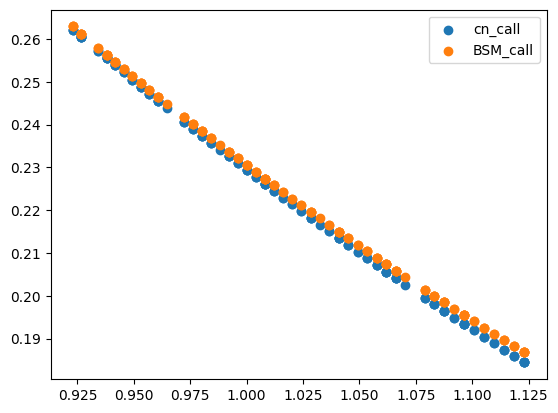

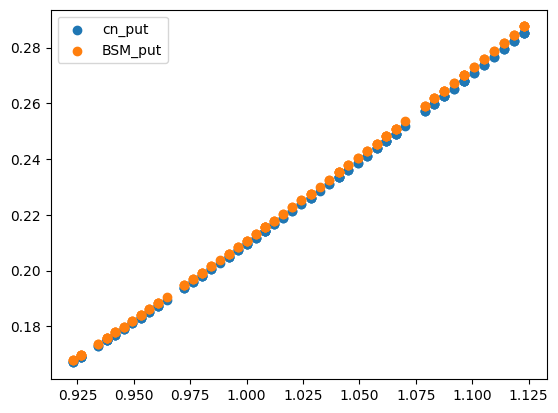

--------------------------------------------------
r: 0.02


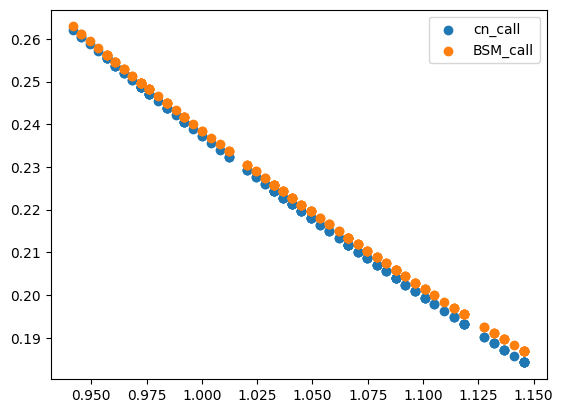

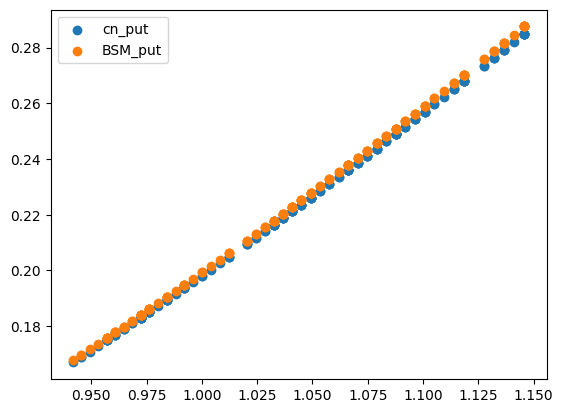

--------------------------------------------------
r: 0.03


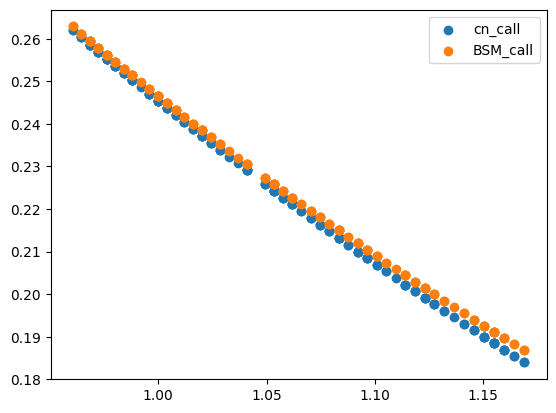

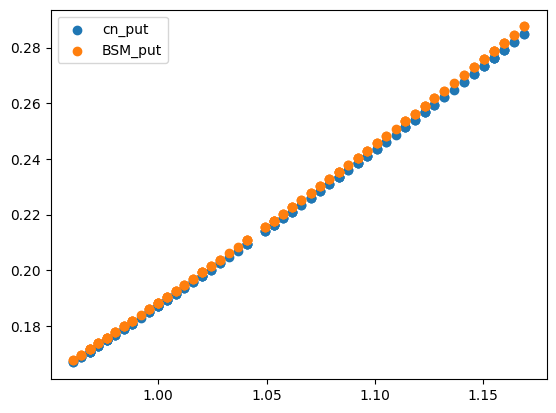

--------------------------------------------------
r: 0.04


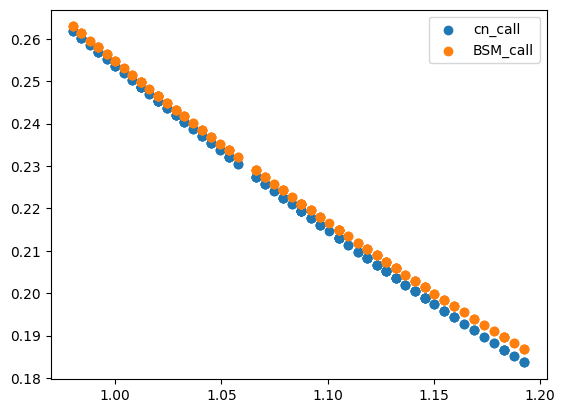

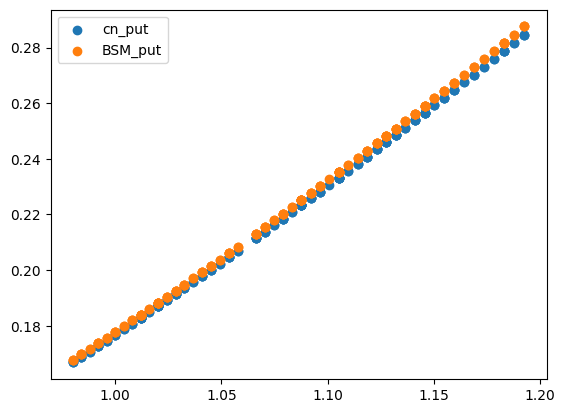

--------------------------------------------------
r: 0.05


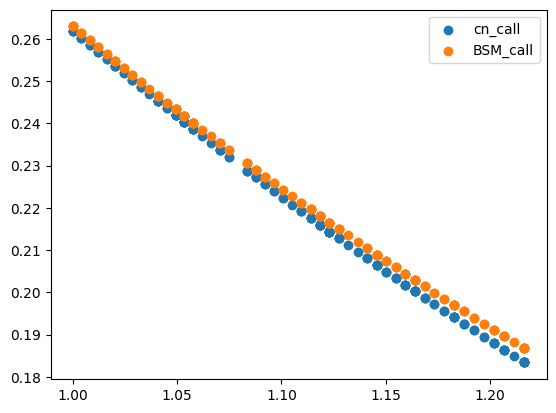

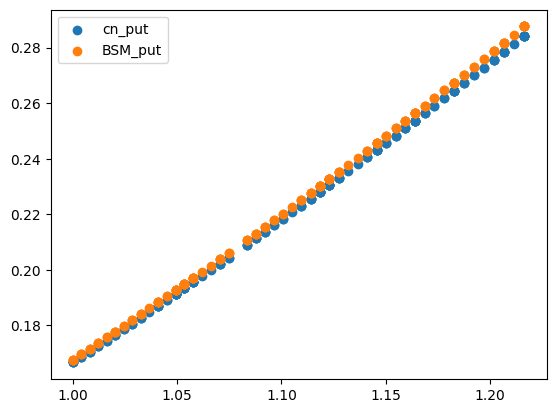

--------------------------------------------------
r: 0.06


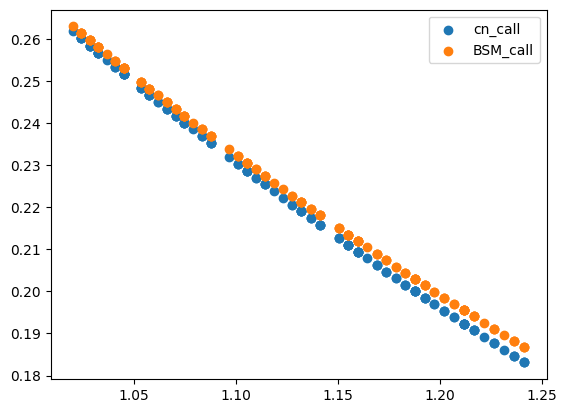

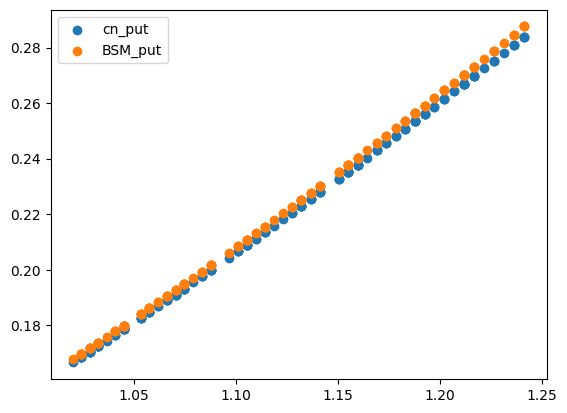

--------------------------------------------------


In [365]:
for i in [0.01,0.02,0.03,0.04,0.05,0.06]:
    print('r:',i)
    tmp_df = out_df[out_df['r']==i].copy()
    
    plt.scatter(tmp_df['strike'], tmp_df['cn_call'], label='cn_call')
    plt.scatter(tmp_df['strike'], tmp_df['BSM_call'], label='BSM_call')
    plt.legend()
    plt.show()
    plt.scatter(tmp_df['strike'], tmp_df['cn_put'], label='cn_put')
    plt.scatter(tmp_df['strike'], tmp_df['BSM_put'], label='BSM_put')
    plt.legend()
    plt.show()
    print('--------------------------------------------------')